In [1]:
import keras
import os
import keras.backend as K
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Using TensorFlow backend.


In [2]:
def get_loss(mask_value):
    
    mask_value = K.variable(mask_value, dtype=K.floatx())
    
    def masked_mse(y_true, y_pred):
        # find out which timesteps in `y_true` are not the padding character
        mask = K.all(K.equal(y_true, mask_value), axis=-1)
        mask = K.expand_dims(1 - K.cast(mask, K.floatx()))
        
        loss = (y_true - y_pred)**2 * mask 

        # take average w.r.t. the number of unmasked entries
        return K.sum(loss) / K.sum(mask)
    
    return masked_mse

masked_mse = get_loss(0)

In [3]:
autoencoder = keras.models.load_model('./bestAutoencoderVHVLGRU_HydrophobicityAndBulkiness.hdf5', 
                                      custom_objects={'masked_mse': masked_mse})

/home/gil/anaconda3/lib/python3.6/site-packages/keras/engine/topology.py:1271: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  return cls(**config)


In [4]:
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
vl_input (InputLayer)           (None, 122, 4)       0                                            
__________________________________________________________________________________________________
vh_input (InputLayer)           (None, 140, 4)       0                                            
__________________________________________________________________________________________________
cu_dnngru_1 (CuDNNGRU)          (None, 16)           1056        vl_input[0][0]                   
__________________________________________________________________________________________________
cu_dnngru_2 (CuDNNGRU)          (None, 16)           1056        vh_input[0][0]                   
__________________________________________________________________________________________________
dense_1 (D

In [5]:
encoder = keras.Model([autoencoder.layers[0].input, autoencoder.layers[1].input], 
                      autoencoder.layers[8].output)

In [6]:
import numpy as np

aa_order = ['ALA', 'CYS', 'ASP', 'GLU', 'PHE', 'GLY', 'HIS', 'ILE',
            'LYS', 'LEU', 'MET', 'ASN', 'PRO', 'GLN', 'ARG', 'SER',
            'THR', 'VAL', 'TRP', 'TYR']

aa3_aa1 = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

def parse_hydrophobicity(file):
    
    scores = np.zeros(20)
    
    with open(file, 'r') as f:
        for line in f:
            if line.startswith('!'):
                continue
                
            el = line.split()
            
            if len(el) > 1:
            
                scores[aa_order.index(el[0])] = float(el[1])
            
    return scores

def parse_bulkiness(file):

    scores = np.zeros(20)
    
    with open(file, 'r') as f:
        for line in f:
            if line.startswith('\n'):
                continue

            el = line.split(':')
            if len(el) > 1:
                scores[aa_order.index(el[0].upper())] = float(el[1])
                
    return scores

vdw_data={"A":0.05702,"R":0.58946,"N":0.22972,"D":0.21051,"C":0.14907,
          "E":0.32837,"Q":0.34861,"G":0.00279,"H":0.37694,"I":0.37671,
          "L":0.37876,"K":0.45363,"M":0.38872,"F":0.55298,"P":0.22790,
          "S":0.09204,"T":0.19341,"W":0.79351,"Y":0.61150,"V":0.25674}
charge_index_data={"A":0.007187,"R":0.043587,"N":0.005392,"D":-0.02382,"C":-0.03661,
                   "E":0.006802,"Q":0.049211,"G":0.179052,"H":-0.01069,"I":0.021631,
                   "L":0.051672,"K":0.017708,"M":0.002683,"F":0.037552,"P":0.239531,
                   "S":0.004627,"T":0.003352,"W":0.037977,"Y":0.023599,"V":0.057004}

CHARACTERS = "ACDEFGHIKLMNPQRSTVWY"

h_data = {aa3_aa1[key]:value for key, value in 
          zip(aa_order, parse_hydrophobicity('../Hydrophobicity/data/consensus.hpb'))}
bulkiness_data = {aa3_aa1[key]:value for key, value in 
          zip(aa_order, parse_bulkiness('./amino_acid_bulkiness.txt'))}

def aa_encoder(sequences, max_length, dataset):
    encoded = np.zeros((len(sequences), max_length))
    
    for i, seq in enumerate(sequences):
        for j, aa in enumerate(seq):
            try:
                encoded[i, j] = dataset[aa]
            except KeyError:
                continue
                
    return encoded

def encode_sequences(sequences, max_length, datasets):
    """
    Assume each dataset provides a 1D encoding per sequence
    """
    
    encoded = np.zeros((len(sequences), max_length, len(datasets)))
    
    for i, dataset in enumerate(datasets):
        encoded[:, :, i] = aa_encoder(sequences, max_length, dataset)        
        
    return encoded

with open('./kabat_animals.html', 'r') as f:
    data = f.readlines()
    
names = [x.split(', ')[0] for x in data[25:-7]]
sequences = [[x.split(', ')[1].strip(), x.split(',')[2].strip()] for x in data[25:-7]]
animals = [x.split(', ')[3].strip() for x in data[25:-7]]

mask = [1 if len(x[0]) >0 and len(x[1]) >0 else 0 for x in sequences]

names_mask = [x for m, x in zip(mask, names) if m==1]
animals_mask = [x for m, x in zip(mask, animals) if m==1]
sequences_mask = [x for m, x in zip(mask, sequences) if m==1]
seq = [x for x in sequences_mask if len(x[0]) > 100]

seq = [[x[0].replace('-',''), x[1].replace('-', '')] for x in seq]
seq = [[x[0].replace('?',''), x[1].replace('?', '')] for x in seq]

CHARACTERS = "ACDEFGHIKLMNPQRSTVWY"
MAX_LENGTH_VH = 140
MAX_LENGTH_VL = 122

VH_sequences = [x[1] for x in seq]
VL_sequences = [x[0] for x in seq]

DATASETS = [h_data, bulkiness_data, vdw_data, charge_index_data]

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

class MinMaxScaler2D(BaseEstimator, TransformerMixin):
    def __init__(self, mask, copy=True):
        """
        Equivalent to StandardScaler but ignores mask, and keeps the value at this position untouched.
        Simpler class as it is only used in this specific case.
        Also is used for RNN processing.
        """
        self.mask = mask
        self.copy = copy
        
    def fit(self, X, y=None):
        # get min and max of this feature2
        self.max_ = (X[X != self.mask]).max()
        self.min_ = (X[X != self.mask]).min()
        
        return self
    
    def transform(self, X, y=None):
        
        check_is_fitted(self, 'max_')
        
        if self.copy:
            X = X.copy()
        mask_ = X == self.mask
        
        X = (X - self.min_) / (self.max_ - self.min_)
        
        X[mask_] = self.mask
        np.nan_to_num(X, copy=False)
        
        return X
    
    def inverse_transform(self, X, y=None):
        
        check_is_fitted(self, 'max_')
        
        if self.copy:
            X = X.copy()
        mask_ = X == self.mask
        
        X = X * (self.max_ - self.min_) + self.min_
            
        X[mask_] = self.mask 
            
        return X
    
class MinMaxScaler3D(BaseEstimator, TransformerMixin):
    def __init__(self, mask, copy=True):
        """
        3D matrix scaling for RNN preparation with mask
        """
        self.copy = copy
        self.mask = mask
        
    def fit(self, X, y=None):
        """Compute the mean and std to be used for later scaling.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape [n_samples, n_features]
            The data used to compute the mean and standard deviation
            used for later scaling along the features axis.
        y : Passthrough for ``Pipeline`` compatibility.
        """
        dims = X.shape
        n_scalers = dims[2]
        # create list of scalers
        self.scalers_ = [MinMaxScaler2D(**self.get_params()) for x in range(n_scalers)]
#         self.scalers_ = [MinMaxScaler() for x in range(n_scalers)]
        # fit each scaler
        for i in range(n_scalers):
            self.scalers_[i].fit(X[:, :, i])
        return self

    def transform(self, X, y=None):
        result = np.empty((X.shape))
        check_is_fitted(self, 'scalers_')
        # check dims
        if len(self.scalers_) != X.shape[2]:
            raise ValueError("Dim 3 must match!")
        for i in range(X.shape[2]):
            # transform data
            result[:, :, i] = self.scalers_[i].fit_transform(X[:, :, i])
        return result
    
    def inverse_transform(self, X, y=None):
        result = np.empty((X.shape))
        check_is_fitted(self, 'scalers_')
        # check dims
        if len(self.scalers_) != X.shape[2]:
            raise ValueError("Dim 3 must match!")
        for i in range(X.shape[2]):
            # transform data
            result[:, :, i] = self.scalers_[i].inverse_transform(X[:, :, i])
        return result
    
    
ss_VH = MinMaxScaler3D(mask=0)
ss_VL = MinMaxScaler3D(mask=0)
VH_encoded = encode_sequences(VH_sequences, MAX_LENGTH_VH, DATASETS)
VL_encoded = encode_sequences(VL_sequences, MAX_LENGTH_VL, DATASETS)
VH_encoded = ss_VH.fit_transform(VH_encoded)
VL_encoded = ss_VL.fit_transform(VL_encoded)

In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
code = encoder.predict([VL_encoded, VH_encoded])

le = LabelEncoder().fit(animals)
labels = le.transform(animals)

unique_labels = np.unique(labels)

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

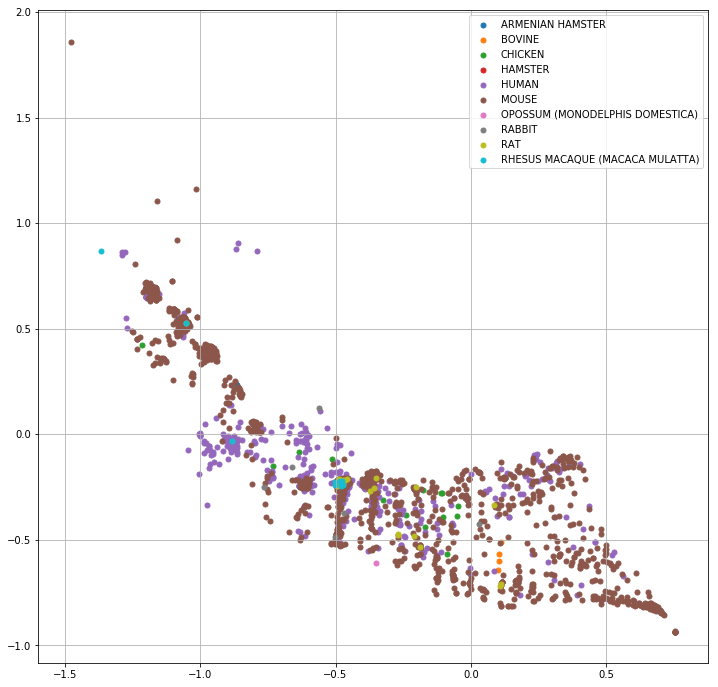

In [10]:
plt.figure(figsize=(12,12))
for x in range(unique_labels.size):
    mask_labels = labels == unique_labels[x]
    plt.scatter(code[mask_labels,0], code[mask_labels,1], marker='.', label=le.classes_[x], s=100)
# plt.ylim([-3,1])
# plt.xlim([-2.5,5])
plt.legend()
plt.grid()

In [11]:
from abpytools import FabCollection, ChainCollection
import pandas as pd

combinations = pd.read_csv('/home/gil/PhD/UCB/precollection/random_pairs.txt', index_col=0, delimiter=', ')

heavy_chains = ChainCollection(path='/home/gil/PhD/UCB/CombinationData/AbFiles/heavy_chains.json')
heavy_chains.load()
light_chains = ChainCollection(path='/home/gil/PhD/UCB/CombinationData/AbFiles/light_chains.json')
light_chains.load()

heavy_chains_list=[]
light_chains_list=[]

for heavy, light in  combinations['Random Pairs'].str.split('-'):
    heavy_chains_list.append(heavy_chains.get_object(heavy))
    light_chains_list.append(light_chains.get_object(light))    
    
fab_collection = FabCollection(None, heavy_chains_list, light_chains_list,
                               names=['P' + str(x) for x in combinations.index.tolist()])

Loading in antibody objects


/home/gil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.



Failed to load 0 objects in list
Loading in antibody objects



Failed to load 0 objects in list


In [12]:
data = pd.read_csv('/home/gil/PhD/UCB/Data/Tm/Processed Data/AllTmData.csv', index_col=0)
data.index = ['P' + str(x) for x in data.index]

In [13]:
VL_data = [''.join(x).replace('-','') for x in fab_collection.numbering_table()['Light'].values]
VH_data = [''.join(x).replace('-','') for x in fab_collection.numbering_table()['Heavy'].values]

In [14]:
VH_data_encoded = encode_sequences(VH_data, MAX_LENGTH_VH, DATASETS)
VL_data_encoded = encode_sequences(VL_data, MAX_LENGTH_VL, DATASETS)

VH_data_encoded = ss_VH.transform(VH_data_encoded)
VL_data_encoded = ss_VL.transform(VL_data_encoded)

In [15]:
code_1 = encoder.predict([VL_data_encoded, VH_data_encoded])

In [16]:
code_1.shape

(900, 2)

In [17]:
latent_data = pd.DataFrame(code_1, columns=['Latent1', 'Latent2'], index=fab_collection.names)

In [18]:
data = pd.read_csv('/home/gil/PhD/UCB/Data/Tm/Processed Data/AllTmData.csv', index_col=0)
data.index = ['P' + str(x) for x in data.index]

In [19]:
data.columns[0]

'Tm D - Mean'

In [20]:
data.dropna(axis=0, inplace=True, subset=[data.columns[0]])

In [21]:
data.shape

(304, 4)

In [22]:
data = data.join(latent_data)

In [23]:
data.head()

,Tm D - Mean,Tm D - Std. Error,Tm2 - Mean,Tm2 - Std. Error,Latent1,Latent2
P2,64.473820,0.000000,NaN,NaN,-1.156256,0.607420
P3,73.982970,0.130358,NaN,NaN,-1.048594,0.474211
P4,64.326010,0.060344,NaN,NaN,-0.864025,-0.057727
P6,74.192370,0.036953,NaN,NaN,-0.341312,-0.302356
P9,72.899025,0.085337,NaN,NaN,-0.632943,-0.010448


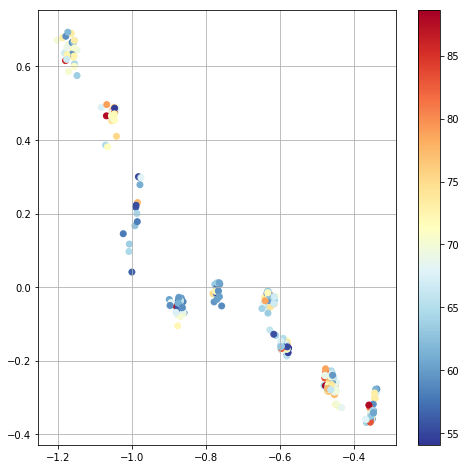

In [24]:
plt.figure(figsize=(8,8))
plt.scatter(data['Latent1'], data['Latent2'], c=data['Tm D - Mean'].values, cmap='RdYlBu_r')
plt.colorbar()
plt.grid()

In [25]:
from sklearn.cluster import KMeans

In [76]:
kmeans = KMeans(9, init='random', random_state=23)
kmeans.fit(data[['Latent1','Latent2']])

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=23, tol=0.0001, verbose=0)

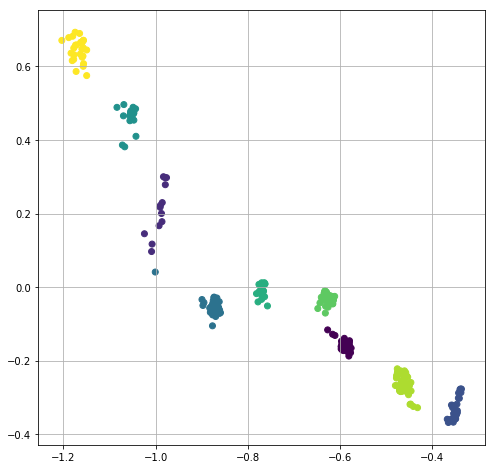

In [77]:
plt.figure(figsize=(8,8))
plt.scatter(data['Latent1'], data['Latent2'], c=kmeans.predict(data[['Latent1','Latent2']]))
plt.grid()

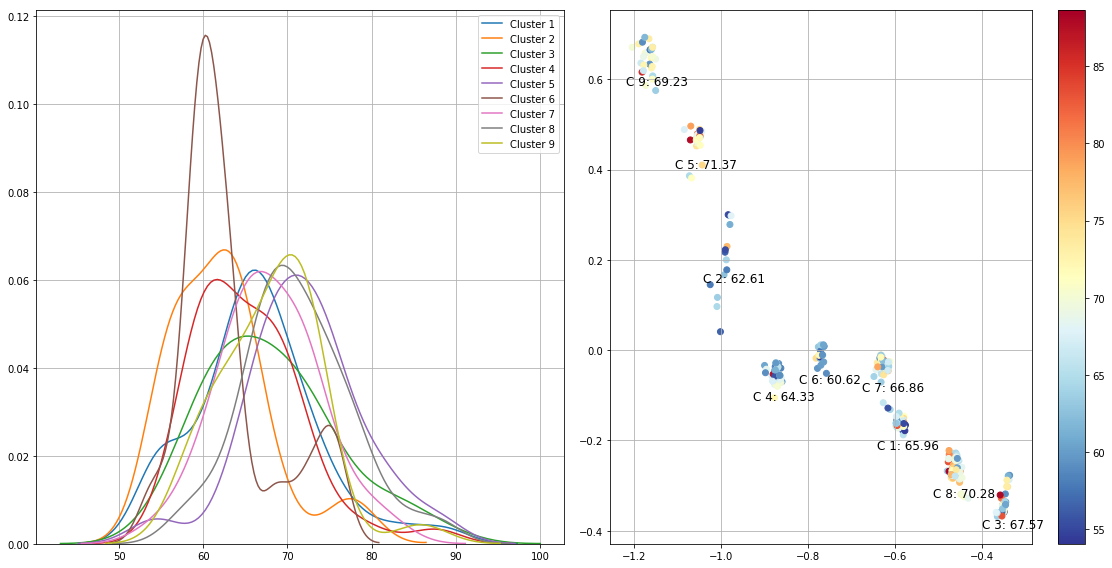

In [107]:
f, ax = plt.subplots(1,2,figsize=(16,8))
kmeans_labels = kmeans.predict(data[['Latent1','Latent2']]) 
tms = ax[1].scatter(data['Latent1'], data['Latent2'], c=data['Tm D - Mean'].values, cmap='RdYlBu_r')
for x in range(9):
    ax[1].text(kmeans.cluster_centers_[x][0]-.05, kmeans.cluster_centers_[x][1]-.06,
               'C {}: {:.2f}'.format(x+1, np.median(data.values[kmeans_labels==x, 0])), fontsize=12)
cbar = f.colorbar(tms)
ax[1].grid()
for x in range(9):
    sns.distplot(data.values[kmeans_labels==x, 0], ax=ax[0], hist=False, label='Cluster {}'.format(x+1))
ax[0].legend()
ax[0].grid()
#     print(data.values[kmeans_labels==x, 0].mean(), data.values[kmeans_labels==x, 0].std())
plt.tight_layout()